### System

The total Hamiltonian of the system is given by:

$
H = H_0 + H_{SB} = H_S + H_{B} + H_{SB}
$

where:
- \( H_S \) is the system Hamiltonian
- \( H_B \) is the bath Hamiltonian
- \( H_{SB} \) is the system-bath interaction Hamiltonian

#### System Hamiltonian

The system Hamiltonian \( H_S \) consists of the dimer Hamiltonian \( H_{dimer} \) and the interaction with the laser field \( H_{I}(t) \):

$
H_S = H_{dimer} + H_{I}(t)
$

The dimer Hamiltonian \( H_{dimer} \) is given by:

$
H_{dimer} = 0 |0\rangle\langle0| + \omega_a |A\rangle\langle A| + \omega_b |B\rangle\langle B| + J (|B\rangle\langle A| + |A\rangle\langle B|) + (\omega_a + \omega_b) |AB\rangle\langle AB|
$

where:
- \( |0\rangle \) is the ground state
- \( |A\rangle \) and \( |B\rangle \) are the excited states with energies \( \omega_a \) and \( \omega_b \) respectively
- \( J \) is the coupling constant between states \( |A\rangle \) and \( |B\rangle \)
- \( |AB\rangle \) is the doubly excited state with energy \( \omega_a + \omega_b \)

The bath Hamiltonian \( H_{B} \) is given by:

$
H_{B} = \sum_k \hbar \omega_k b_k^{\dagger} b_k
$

where:
- \( \hbar \omega_k \) is the energy of the \( k \)-th bath mode
- \( b_k^{\dagger} \) and \( b_k \) are the creation and annihilation operators for the \( k \)-th bath mode

The interaction Hamiltonian \( H_{I}(t) \) is given by:

$
H_{I}(t) = \hbar  g ( \Sigma_+ + \Sigma_-) \cdot (f(t) + f(t)^{*})
$

where:
- \( \Sigma_+ \) and \( \Sigma_- \) are the raising and lowering operators
- \( f(t) \) is the time-dependent field
- \( g =  \mu \cdot E_0 \) is the coupling constant with \( \mu \) being the dipole moment and \( E_0 \) the field amplitude

The electric field \( E(t) \) is defined as:

$
E(t) \equiv f(t) \cdot E_0 \propto \exp^{i \omega_a t + \phi} \cdot \delta(t)
$

### Decay Operators

The decay operators are defined as:

$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$

where:
- \( \gamma_0 \) is the decay rate
- \( \gamma_\phi \) is the dephasing rate
- \( \sigma_-^{(i)} \) and \( \sigma_z^{(i)} \) are the Pauli operators for the \( i \)-th state

In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import scipy.constants as const
import matplotlib as mpl
from qutip import *
import numpy as np
import itertools
import os

# Matplotlib settings according to LaTeX caption formatting
#mpl.rcdefaults() # resets all the settings to their default values
plt.rcParams.update({
    'text.usetex': True,               # Enable LaTeX for text rendering    
    'font.family': 'serif',            # Use a serif font family   
    'font.serif': 'Palatino',         # Set Palatino as the serif font
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 20,                   # Font size for general text
    'axes.titlesize': 20,              # Font size for axis titles
    'axes.labelsize': 20,              # Font size for axis labels
    'xtick.labelsize': 20,             # Font size for x-axis tick labels
    'ytick.labelsize': 20,             # Font size for y-axis tick labels
    'legend.fontsize': 20,             # Font size for legends
    'figure.figsize': [8, 6],          # Size of the plot (width x height)
    'figure.autolayout': True,         # Automatic layout adjustment
    'savefig.format': 'svg',           # Default format for saving figures
    'figure.facecolor': 'none',        # Make the figure face color transparent
    'axes.facecolor': 'none',          # Make the axes face color transparent
    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = os.path.join(os.getcwd(), 'output')  # Creates an 'output' directory in the current working directory
mpl.use('Agg')  # Use a non-interactive backend
os.makedirs(output_dir, exist_ok=True)
# Allows for interactive plots
# %matplotlib notebook
%matplotlib inline

# Phase Cycling for Averaging
phases = [np.pi / 2 for i in range(4)]  # GIVES WEIRD RESULTS

# Constants
Boltzmann = 1  # * const.Boltzmann
hbar      = 1  # * const.hbar
c         = 1  # * const.c
print(f"Reduced Planck's constant (hbar): {hbar} J·s,\nBoltzmann constant (k_B): {Boltzmann} J/K,\nSpeed of light (c): {c} m/s")

# System parameters
fac_twopi = 1 * 2 * np.pi
# Delta = 200  # Inhomogeneous distribution width of the monomer transitions (cm⁻¹, actually also s⁻1, when c = 1)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Reduced Planck's constant (hbar): 1 J·s,
Boltzmann constant (k_B): 1 J/K,
Speed of light (c): 1 m/s


In [2]:
# =============================
# SYSTEM PARAMETERS
# =============================
# Example usage
N_atoms = 1  # Set the number of atoms
Coupled = False  # Set coupling condition



# Define Atomic States
atom_g, atom_e = basis(2, 0), basis(2, 1)      # Ground, Excited states

omega_L = 1.005     # on resonance / in the middle of the two transitions 
E_freqs = [omega_L] * 3 # Laser frequencies

E0      = 1e-19 * 1.509 * 10**18
E_amps  = [E0, E0, 1e-2 * E0]


# Initialize variables that are shared across cases but may be not used in one
omega_b, mu_b, rabi_0, rabi_gen, delta, theta, J, gamma_ab, Gamma_ab = None, None, None, None, None, None, None, None,None

if N_atoms == 1:
    psi_ini = atom_g
    omega_a = 1.005  # [fs⁻¹] = 16000 cm-1

    mu_a    = 1
    g_value = mu_a * E0
    rabi_0  = g_value / hbar

    H0 = hbar * omega_a * ket2dm(atom_e)
    eigenenergies, eigenstates = H0.eigenstates()

    delta    = omega_a - omega_L
    rabi_gen = np.sqrt(rabi_0**2 + delta**2)

    # Define variables common to both cases
    gamma_0, gamma_phi = 1 / (300), 1 / (100)  # Decay and Dephasing rates with MESOLVE
    pulse_duration = 15
    Delta_ts = [pulse_duration / 2] * 3
    fine_spacing = .01


    t_max_L = 6 * 2 * np.pi / omega_L
    t_prd   = 2 * np.pi / rabi_gen
    t_max_r = max(600, 5 * t_prd)
    t_max   = t_max_r

    SM_op   = mu_a * (atom_g * atom_e.dag()).unit()
    Dip_op  = SM_op + SM_op.dag()
    Deph_op = -atom_g * atom_g.dag() + atom_e * atom_e.dag()

    c_ops_list = [np.sqrt(gamma_0) * SM_op, np.sqrt(gamma_phi) * Deph_op]
    wc = 30*omega_a # Cutoff frequency for the bath spectral density
    g = .1           # Coupling strength to bath modes
    def ohmic_spectrum(w):
        return g * w/wc * np.exp(-w / wc) * ( w > 0.0) #  gamma_0 * (w > 0.0 )#
    a_ops_list = [[Dip_op, ohmic_spectrum],]
elif N_atoms == 2:
    psi_ini = tensor(atom_g, atom_g)

    pulse_duration = 5
    Delta_ts = [pulse_duration / 2] * 3
    fine_spacing = .1

    def Hamilton_dimer_sys(hbar, omega_a, omega_b, J):
        H = hbar * (omega_a * ket2dm(tensor(atom_e, atom_g))
                    + omega_b * ket2dm(tensor(atom_g, atom_e))
                    + J * (tensor(atom_e, atom_g) * tensor(atom_g, atom_e).dag() + tensor(atom_g, atom_e) * tensor(atom_e, atom_g).dag())
                    + (omega_a + omega_b) * ket2dm(tensor(atom_e, atom_e)))
        return H

    # If the excited states are coupled -> modify the energy levels
    if Coupled:
        def calc_mu(H, mu_a, mu_b, theta):
            eigenvecs = H.eigenstates()[1]
            mu_10 = -mu_a * np.sin(theta) + mu_b * np.cos(theta)
            sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()
            if N_atoms == 1:
                return [(sigma_m_10 + sigma_m_10.dag())], [sigma_m_10]

            mu_20 =  mu_a * np.cos(theta) + mu_b * np.sin(theta)
            mu_31 = -mu_b * np.sin(theta) + mu_a * np.cos(theta)
            mu_32 =  mu_b * np.cos(theta) + mu_a * np.sin(theta)

            sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()
            sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()
            sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()

            return [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]

        J = 0.01885  # fac_twopi * c * 300
        omega_a = 1.018  # fac_twopi * c * 16200
        omega_b = 0.9927  # fac_twopi * c * 15800
        mu_a = 1
        mu_b = -0.23

        theta = np.arctan(2 * J / (omega_a - omega_b)) / 2

        H0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)
        eigenenergies, eigenstates = H0.eigenstates()
        sm_list = calc_mu(H0, mu_a, mu_b, theta) 

    else:
        J = 0.0
        omega_a = 1.028  # fac_twopi * c * 16360
        omega_b = 0.9827  # fac_twopi * c * 15640
        mu_a = 1
        mu_b = mu_a

        H0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)
        eigenenergies, eigenstates = H0.eigenstates()
        sm_list = [mu_a * tensor(atom_g * atom_e.dag(), qeye(2)), mu_a * tensor(qeye(2), atom_g * atom_e.dag())]

    g_value = mu_a * E0
    t_prd = 2 * np.pi * hbar / (g_value)
    t_max_r = max(600, 5 * t_prd)
    t_max = t_max_r

    SM_op   = sum(sm_list)
    Dip_op  = SM_op + SM_op.dag()
    Deph_op =  tensor(-atom_g* atom_g.dag() + atom_e* atom_e.dag(), qeye(2)) + tensor(qeye(2), -atom_g* atom_g.dag() + atom_e* atom_e.dag())
    #Deph_op = -eigenstates[0] * eigenstates[0].dag() + sum([state * state.dag() for state in eigenstates[1:]]) # TODO now sure which one is correct

    # Coupling to the bath
    T = 1e-2 # Temperature
    g = 1
    wc = 30*omega_a
    def n(w):
        return 1 / (np.exp(w * (Boltzmann * T)**-1) - 1)
    def ohmic_spectrum(w):
        return g**2 * w / wc * np.exp(-w / wc) * (w > 0.0)
    """def Corr_fct(w):
            if w > 0:
                return n(w) * ohmic_spectrum(w)
            elif w < 0:
                return (1 + n(-w)) * ohmic_spectrum(-w)
            else:
                return g**2 / (wc * (Boltzmann * T)**-1)
        def gamma_ab(w):
            return np.sin(2 * theta)**2 * Corr_fct(w)
        Gamma_ab = 2 * np.cos(2 * theta)**2 * Corr_fct(0)
        decay_rates = [gamma_ab(wa - wb) for wa in eigenenergies for wb in eigenenergies] + [Gamma_ab] * 4
        #decay_rates = [rate for rate in decay_rates if rate != 0] # Remove zero rates
        #print(decay_rates)"""

    c_ops_list = [np.sqrt(gamma_0) * SM_op, np.sqrt(gamma_phi) * Deph_op]
    a_ops_list = [[Dip_op, ohmic_spectrum],]
else:
    raise ValueError("can only handle 1 or 2 atoms")

e_ops_list   = [ket2dm(v) for v in H0.eigenstates()[1]]
e_ops_labels = [f"state{i}" for i in range(len(H0.eigenstates()[1]))]

In [3]:
# Test
"""def calc_mu(H, mu_a, mu_b, theta):
    eigenvecs = H.eigenstates()[1]
    mu_10 = -mu_a * np.sin(theta) + mu_b * np.cos(theta)
    sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()
    if N_atoms == 1:
        return [(sigma_m_10 + sigma_m_10.dag())], [sigma_m_10]

    mu_20 =  mu_a * np.cos(theta) + mu_b * np.sin(theta)
    mu_31 = -mu_b * np.sin(theta) + mu_a * np.cos(theta)
    mu_32 =  mu_b * np.cos(theta) + mu_a * np.sin(theta)

    sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()
    sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()
    sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()

    return [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]

J = 0.0
omega_a = 1.028  # fac_twopi * c * 16360
omega_b = 0.9827  # fac_twopi * c * 15640
mu_a = 1
mu_b = mu_a
theta = np.arctan(2 * J / (omega_a - omega_b)) / 2

H0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)
#print(H0)
eigenenergies, eigenstates = H0.eigenstates()
sm_list = calc_mu(H0, mu_a, mu_b, theta) 
SM_op   = sum(sm_list)
Dip_op  = SM_op + SM_op.dag()
Deph_op = -eigenstates[0] * eigenstates[0].dag() + sum([state * state.dag() for state in eigenstates[1:]])
print(SM_op, Dip_op, Deph_op)

sm_list = [tensor(atom_g * atom_e.dag(), qeye(2)), tensor(qeye(2), atom_g * atom_e.dag())]
SM_op   = sum(sm_list)
Dip_op  = SM_op + SM_op.dag()
Deph_op =  tensor(-atom_g* atom_g.dag() + atom_e* atom_e.dag(), qeye(2)) + tensor(qeye(2), -atom_g* atom_g.dag() + atom_e* atom_e.dag())
print(SM_op, Dip_op, Deph_op)"""

'def calc_mu(H, mu_a, mu_b, theta):\n    eigenvecs = H.eigenstates()[1]\n    mu_10 = -mu_a * np.sin(theta) + mu_b * np.cos(theta)\n    sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()\n    if N_atoms == 1:\n        return [(sigma_m_10 + sigma_m_10.dag())], [sigma_m_10]\n\n    mu_20 =  mu_a * np.cos(theta) + mu_b * np.sin(theta)\n    mu_31 = -mu_b * np.sin(theta) + mu_a * np.cos(theta)\n    mu_32 =  mu_b * np.cos(theta) + mu_a * np.sin(theta)\n\n    sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()\n    sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()\n    sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()\n\n    return [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]\n\nJ = 0.0\nomega_a = 1.028  # fac_twopi * c * 16360\nomega_b = 0.9827  # fac_twopi * c * 15640\nmu_a = 1\nmu_b = mu_a\ntheta = np.arctan(2 * J / (omega_a - omega_b)) / 2\n\nH0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)\n#print(H0)\neigenenergies, eigenstates = 

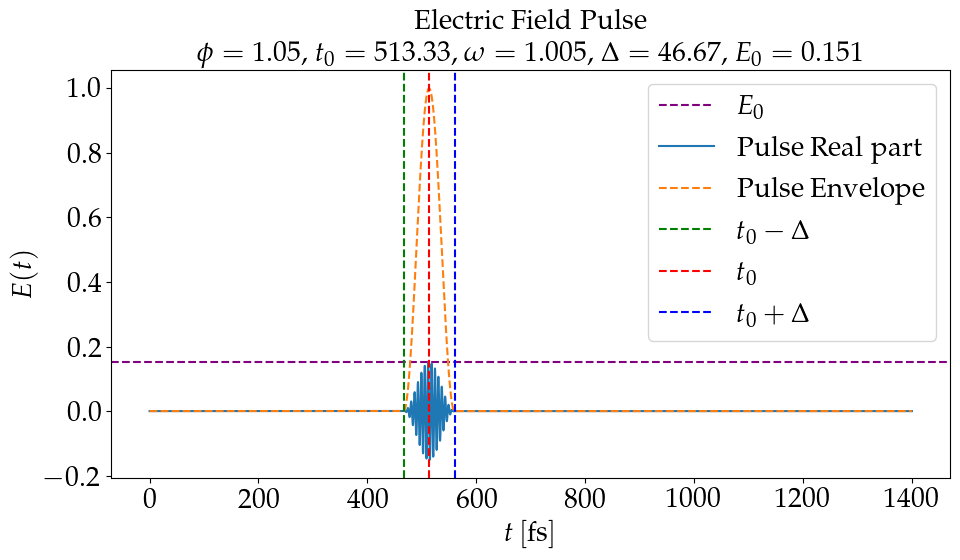

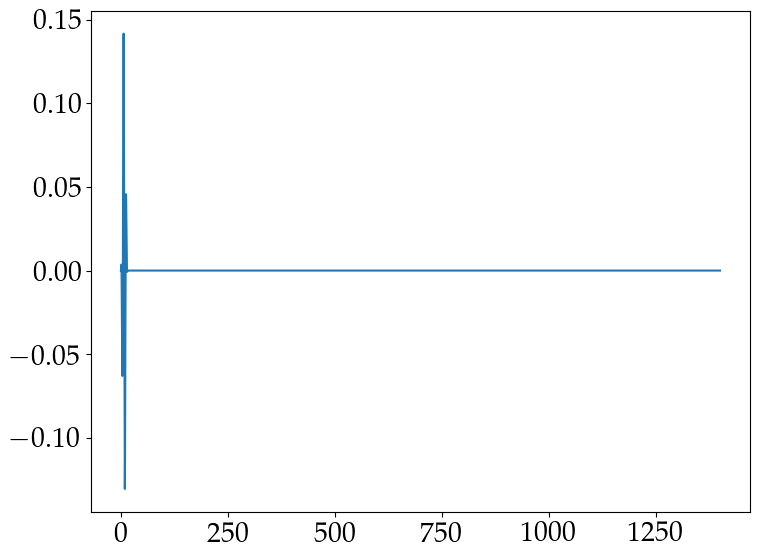

 Total run time:  81.81s*] Elapsed 81.81s / Remaining 00:00:00:00          2%           ] Elapsed 1.57s / Remaining 00:00:01:16[*         3%           ] Elapsed 3.00s / Remaining 00:00:01:37[*         5%           ] Elapsed 4.75s / Remaining 00:00:01:30[**        8%           ] Elapsed 7.33s / Remaining 00:00:01:24[**        9%           ] Elapsed 7.56s / Remaining 00:00:01:16[*****    23%           ] Elapsed 18.93s / Remaining 00:00:01:03[******   24%           ] Elapsed 19.75s / Remaining 00:00:01:02[******   25%           ] Elapsed 20.38s / Remaining 00:00:01:01[******   28%           ] Elapsed 22.88s / Remaining 00:00:00:58[*******  32%           ] Elapsed 26.50s / Remaining 00:00:00:56[*********39%           ] Elapsed 32.50s / Remaining 00:00:00:50[*********45%           ] Elapsed 37.26s / Remaining 00:00:00:45[*********56%*          ] Elapsed 45.91s / Remaining 00:00:00:36[*********60%**         ] Elapsed 49.12s / Remaining 00:00:00:32[*********65%***        ] Elapsed 53.34s / Re

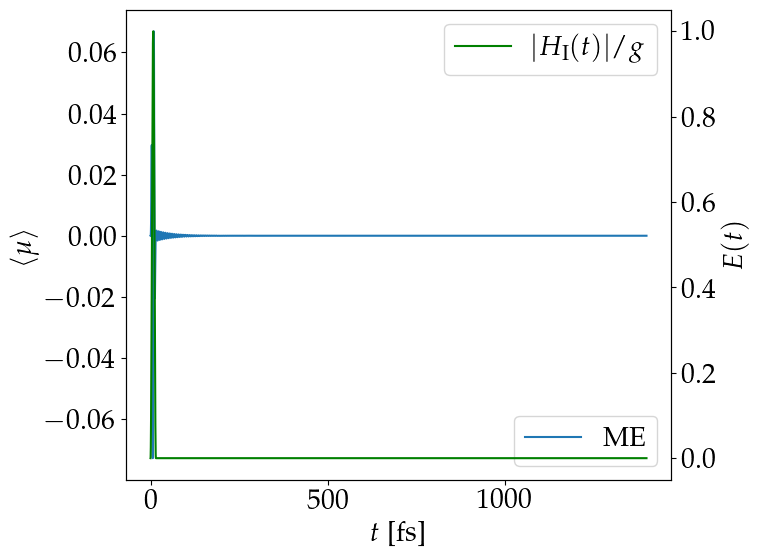

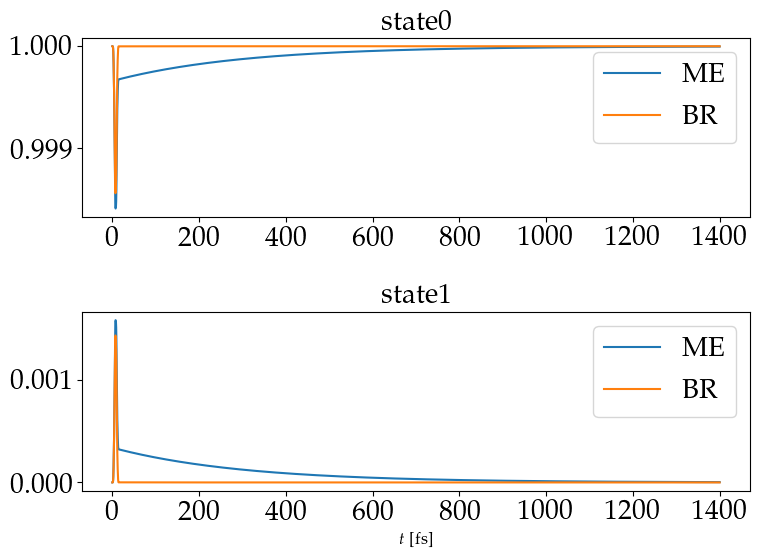

In [ ]:
# =============================
# MORE FUNCTIONS
# =============================
def plot_positive_color_map(datas, T=np.inf, space="real", type="real", positive=False, safe=False, output_dir=None): 
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        datas (tuple): Tuple containing (x, y, data) where x and y are 1D arrays and data is a 2D array.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.
        output_dir (str, optional): Directory to save the plot.

    Returns:
        None
    """
    # Ensure datas is a tuple with (x, y, data)
    if not isinstance(datas, tuple) or len(datas) != 3:
        raise ValueError("datas must be a tuple of (x, y, data)")

    x, y, data = datas

    # Validate that x, y, and data are numpy arrays
    x = np.array(x)
    y = np.array(y)
    data = np.array(data)

    # Check if data dimensions match x and y
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Filter for positive x and y values if requested
    if positive:
        positive_x_indices = np.where(x > 0)[0]
        positive_y_indices = np.where(y > 0)[0]
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    # Set the label and title based on the space
    label = r"$\propto E_{\text{out}} / \mu_{\text{a}}$"
    if space == "real":
        colormap = "viridis"
        title = r"$\text{Real space 2D Spectrum}$"
        if T != np.inf:
            title += f" \text{{at}} T ={T:.2f}"
        x_title = r"$t_{\text{det}}$ [fs]"
        y_title = r"$\tau_{\text{coh}}$ [fs]"

    elif space == "freq":
        x = x * 10 / 3
        y = y * 10 / 3
        colormap = "plasma"
        if type == "real":
            title = r"$\text{Freq space, Real 2D Spectrum}$"
            data = np.real(data)
        elif type == "imag":
            title = r"$\text{Freq space, Imag 2D Spectrum}$"
            data = np.imag(data)
        elif type == "abs":
            title = r"$\text{Freq space, Abs 2D Spectrum}$"
            data = np.abs(data)
        elif type == "phase":
            title = r"$\text{Freq space, Phase 2D Spectrum}$"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")
        
        if T != np.inf:
            title += f" \text{{at}} T ={T:.2f}"

        x_title = r"$\omega_{t_{\text{det}}}$ [$10^4$ cm$^{-1}$]"
        y_title = r"$\omega_{\tau_{\text{coh}}}$ [$10^4$ cm$^{-1}$]"
    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / mu_a, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True and output_dir is provided
    if safe and output_dir is not None:
        assert os.path.isdir(output_dir), f"Output directory {output_dir} does not exist."

        filename_parts = [
            f"N={N_atoms}",
            f"mua={mu_a:.0f}",
            f"E0={E0:.2e}",
            f"wa={omega_a:.2f}",
            f"wL={omega_L / omega_a:.1f}wa",
            f"g={g_value:.2e}",
            f"rabi0={rabi_0:.2f}",
            f"delta={delta:.2f}",
            f"rabigen={rabi_gen:.2f}",
            f"g0={gamma_0:.3f}",
            f"gphi={gamma_phi:.3f}",
            f"pos={positive}",
            f"space={space}"
        ]

        if N_atoms == 2 and J is not None:
            filename_parts.insert(1, f"J_{J:.1f}")

        if space == "freq":
            filename_parts.append(f"type_{type}")

        file_name_combined = "_".join(filename_parts) + ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)
    else:
        print("Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.")

    plt.show()

def Plot_example_evo(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k):
    args0 = get_pulse_args(times_0[0], 0, phi_1)
    args1 = get_pulse_args(times_0[i], 1, phi_2)
    args2 = get_pulse_args(times_1[j-i], 2, 0)

    times1 = times_0[:i]
    times2 = times_1[:j]
    times3 = times_2

    # Calculate the electric fields for each time range
    E_1 = [E_amps[0] * (El_field_pulse(t, args0)) for t in times1]
    E_2 = [E_amps[1] * (El_field_pulse(t, args1)) for t in times2]
    E_3 = [E_amps[2] * (El_field_pulse(t, args2)) for t in times3]
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    fig, axs = plt.subplots(len(e_ops_list)+1, 1, figsize=(15, 10), sharex=True)

    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
    axs[0].set_ylabel('E')

    # Add vertical lines to mark pulse times
    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
    axs[0].axvline(times_1[j-i] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
    axs[0].axvline(times_2[k], color='b', linestyle='--', label='Detection')
    axs[0].legend()

    # Initialize an empty list to store all the data for plotting
    datas = []

    # Append the data for each quantum state based on the times
    for idx in range(len(e_ops_list)):
        datas.append(np.concatenate([data_1.expect[idx][:i], data_2.expect[idx][:j], data_f.expect[idx]]))  # data for first state

    # Loop over the datas and plot each expectation value
    for idx, (data, label) in enumerate(zip(datas, e_ops_labels)):
        axs[idx+1].plot(times_plot, data)
        axs[idx+1].set_ylabel(label)
        axs[idx+1].legend()

    fig.suptitle(f"tau = {tau:.2f}, T = {T_val:.2f}")
    axs[-1].set_xlabel('t [fs]')
    plt.show()
def Plot_example_evo_with_DipOp(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k):
    args0 = get_pulse_args(times_0[0], 0, phi_1)
    args1 = get_pulse_args(times_0[i], 1, phi_2)
    args2 = get_pulse_args(times_1[j-i], 2, 0)

    times1 = times_0[:i]
    times2 = times_1[:j]
    times3 = times_2

    # Calculate the electric fields for each time range
    E_1 = [E_amps[0] * (El_field_pulse(t, args0)) for t in times1]
    E_2 = [E_amps[1] * (El_field_pulse(t, args1)) for t in times2]
    E_3 = [E_amps[2] * (El_field_pulse(t, args2)) for t in times3]
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

    # Plot the electric field
    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
    axs[0].set_ylabel('E')

    # Add vertical lines to mark pulse times
    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
    axs[0].axvline(times_1[j-i] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
    axs[0].axvline(times_2[k], color='b', linestyle='--', label='Detection')
    axs[0].legend()

    # Initialize an empty list to store all the expectation values of Dip_op
    datas = []
    expect_1 = [expect(Dip_op, state) for state in data_1.states]
    expect_2 = [expect(Dip_op, state) for state in data_2.states]
    expect_f = [expect(Dip_op, state) for state in data_f.states]
    # Append the expectation value of Dip_op for each state at the corresponding times
    for data in [data_1, data_2, data_f]:
        # Calculate expect(Dip_op, psi) at the appropriate indices
        datas.append(np.concatenate([expect_1[:i], expect_2[:j], expect_f]))

    # Plot the expectation values for each state
    for data in datas:
        axs[1].plot(times_plot, data)

    axs[1].set_ylabel('Expectation of Dip_op')
    axs[1].legend()

    fig.suptitle(f"tau = {tau:.2f}, T = {T_val:.2f}")
    axs[-1].set_xlabel('t [fs]')
    plt.show()
def get_t_tau_times_for_T(T_val, spacing):
    # Adjust the first and last entries of times_tau
    first_tau = (Delta_ts[0] + Delta_ts[1])
    last_tau = np.floor((t_max - Delta_ts[2] - T_val - Delta_ts[0]) / spacing) * spacing
    times_tau = np.arange(first_tau, last_tau, spacing)
    # Adjust the first and last entries of times_t
    first_t = (Delta_ts[2])
    last_t = np.floor((t_max - Delta_ts[0] - T_val - 2 * Delta_ts[2]) / spacing) * spacing
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t
# THE electrical field pulse(s) are defined here:
def get_pulse_args(t, i, phi):
    return {
        'phi': phi,
        'time': t + Delta_ts[i],
        'omega': E_freqs[i],
        'Delta': Delta_ts[i],
        'E_amp': E_amps[i]
    }
def pulse_envelope(t, t0, Delta):
    Env = np.cos(np.pi * (t - t0) / (2 * Delta))**2 * np.heaviside(t - (t0 - Delta), 0) * np.heaviside(t0 + Delta - t, 0)
    return Env
    #"""Gaussian envelope function centered at t0 with width Delta."""
    #return np.exp(-((t - t0) ** 2) / (2 * Delta/2 ** 2))
# Plot the pulse envelope over times
def El_field_pulse(t, args):
    """ Define a time-dependent electric field pulse. """
    t0, Delta, omega, phi, E0 = args['time'], args['Delta'], args['omega'], args['phi'], args['E_amp']
    Env = pulse_envelope(t, t0, Delta)
    E   = np.exp(-1j * (omega * t + phi)) #     phase kick
    return  E0 * Env * E
def El_field_op_pulse(t, args):
    E = El_field_pulse(t, args)
    E_op = E + np.conj(E)
    return E_op / 2    # to normalize the Electric field = Real part of the Electric field

def plot_pulse_envelope(times, t0, Delta, ax=None):
    """Plot the pulse envelope over times."""
    envelope = [pulse_envelope(t, t0, Delta) for t in times]
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(times, envelope, label=r"$\text{Pulse Envelope}$", linestyle='--')
    ax.axvline(t0 - Delta, color='g', linestyle='--', label=r"$t_0 - \Delta$")
    ax.axvline(t0, color='r', linestyle='--', label=r"$t_0$")
    ax.axvline(t0 + Delta, color='b', linestyle='--', label=r"$t_0 + \Delta$")
    return ax
def plot_El_field_pulse(times, args):
    """Plot the pulse envelope over times."""
    El_field_pulse_data = [np.real(El_field_pulse(t, args)) for t in times]
    t0 = args['time']
    Delta = args['Delta']
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axhline(args['E_amp'], color='purple', linestyle='--', label=r"$E_0$")
    ax.plot(times, El_field_pulse_data, label=r"$\text{Pulse Real part}$")
    ax = plot_pulse_envelope(times, t0, Delta, ax=ax)
    
    ax.set_xlabel(r'$t \, [\text{fs}]$')
    ax.set_ylabel(r'$E(t)$')
    ax.set_title(r'$\text{Electric Field Pulse}$' + 
    f"\n$\\phi={args['phi']:.2f}$, $t_0={args['time']:.2f}$, $\\omega={args['omega']:.3f}$, $\\Delta={args['Delta']:.2f}$, $E_0={args['E_amp']:.3f}$")
    ax.legend()
    plt.show()

def process_one_combination(phi_1, phi_2, times_T):
    # Function to handle parallel processing for each phi1, phi2 combination
    full_data_array = np.empty((len(times_T)), dtype=object)
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(compute_two_dimensional_polarization, times_T[i], phi_1, phi_2) for i in range(len(times_T))]
        for i, future in enumerate(as_completed(futures)):
            full_data_array[i] = future.result()
    return full_data_array
def parallel_process_all_combinations(phases, times_T):
    # Call the function to parallelize the whole process
    all_results = {}
    with ProcessPoolExecutor() as executor:
        futures = [(executor.submit(process_one_combination, phi1, phi2, times_T), phi1, phi2) for phi1, phi2 in itertools.product(phases, phases)]
        for future, phi1, phi2 in futures:
            all_results[(phi1, phi2)] = future.result()
    return all_results
def average_the_results(results, times_T):
    # the time data can even be padded
    num_combinations = len(results)
    num_time_steps = len(times_T) - 1
    averaged_data_array = np.empty(num_time_steps, dtype=object)
    for i in range(num_time_steps):
        sum_data = None
        ts, taus = None, None
        for _, full_data_array in results.items():
            ts, taus, data_time = full_data_array[i]
            if sum_data is None:
                sum_data = np.zeros_like(data_time)
            sum_data += data_time
        averaged_data = sum_data / num_combinations
        pad_val = 1
        padded_size = (int(np.round(averaged_data.shape[0] * pad_val)), int(np.round(averaged_data.shape[1] * pad_val)))
        padded_averaged_data = np.pad(averaged_data, ((0, padded_size[0] - averaged_data.shape[0]), (0, padded_size[1] - averaged_data.shape[1])), mode='constant', constant_values=0)
        padded_ts = np.linspace(ts[0], np.round(ts[-1] * pad_val), padded_size[1])
        padded_taus = np.linspace(taus[0], np.round(taus[-1] * pad_val), padded_size[0])
        averaged_data_array[i] = (padded_ts, padded_taus, padded_averaged_data)
    return averaged_data_array
def get_all_results(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1] for k, v in all_results.items()}
    averaged_results = average_the_results(sorted_results, times_T)
    return averaged_results
def extend_and_plot_results(averaged_results):
    global_ts        = averaged_results[0][0]
    global_taus      = averaged_results[0][1]
    global_t_freqs   = np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0]))
    global_tau_freqs = np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0]))
    global_data_time = np.zeros((len(global_taus), len(global_ts)))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    def find_closest_index(local_times, global_times):
        return [np.argmin(np.abs(global_times - local_time)) for local_time in local_times]

    for i, datas in enumerate(averaged_results):
        (ts, taus, data_time)
        data_extended_time = np.zeros_like(global_data_time)
        tau_indices = find_closest_index(datas[1], global_taus)
        t_indices = find_closest_index(datas[0], global_ts)
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                data_extended_time[global_tau_idx, global_t_idx] = datas[2][local_tau_idx, local_t_idx]
        data_extended_freq = np.fft.fft2(data_extended_time)
        global_data_time += data_extended_time
        global_data_freq += data_extended_freq
        plot_positive_color_map(datas, times_T[i])
        plot_positive_color_map((global_t_freqs, global_tau_freqs, data_extended_freq), times_T[i], space="freq", positive=True, type="abs")

    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)
    plot_positive_color_map((global_ts, global_taus, global_data_time), safe=False)
    plot_positive_color_map((global_t_freqs, global_tau_freqs, global_data_freq), space="freq", type="abs", positive=True, safe=False)
    return global_data_time, global_data_freq

def H_int(t, args): 
    # is it a problemm, that mu_a and N_atoms is not passed as an argument 
    E0 = args['E_amp']
    g = E0 * mu_a
    # RWA
    return g * ((SM_op * El_field_pulse(t, args) + 
                SM_op.dag() * np.conj(El_field_pulse(t, args)))
                  / (E0 * 2 * N_atoms * mu_a))  # to normalize the Dipole operator; NOT Correct for 2 atoms with mu_a != mu_b
    # NO RWA
    return g * (Dip_op / (2 * N_atoms)) * (El_field_op_pulse(t, args) / (E0))  # to normalize the Dipole operator; El_field_op_pulse(.) = 2 cos(wt + phi)
def H_sys(args):
    ### Define the system Hamiltonian as the atomic Hamiltonian plus the Dipole interaction with the electric field
    return H0 + QobjEvo(H_int, args)

def get_all_results(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1] for k, v in all_results.items()}
    averaged_results = average_the_results(sorted_results, times_T)
    return averaged_results


### DEBUGGING
# Compute only the first pulse
def test_evo_of_first_pulse(test_args, times, e_ops_list, e_ops_labels, g_value):
    progress_bar = 'enhanced'
    options = {'store_states': True, 'progress_bar': progress_bar} # safe the states, because I need to start the next pulse from the last state

    result_me = mesolve(H_sys(test_args), psi_ini, times, c_ops=c_ops_list, e_ops=e_ops_list, args=test_args, options=options)
    result_br = brmesolve(H_sys(test_args), psi_ini, times, a_ops=a_ops_list, e_ops=e_ops_list, args=test_args, options=options)

    fig, ax1 = plt.subplots()
    ax1.plot(times, expect(Dip_op, result_me.states), label=r"\text{ME}")
#    ax1.plot(times, expect(Dip_op, result_br.states), label=r"\text{BR}")
    ax1.set_xlabel(r"$t$ [fs]")
    ax1.set_ylabel(r"$\langle \mu \rangle$")
    ax2 = ax1.twinx()
    ax2.plot(times, [H_int(t, test_args).norm() / g_value for t in times], label=r"$|H_\text{I}(t)|/g$", color='green')
    ax2.set_ylabel(r"$E(t)$")
    ax1.legend(loc="lower right")
    ax2.legend(loc="upper right")

    fig, axes = plot_expectation_values([result_me, result_br])
    for ax, label in zip(axes, e_ops_labels):
        ax.legend(labels=[r"\text{ME}", r"\text{BR}"])
        ax.set_title(label)
    plt.xlabel(r"$t$ [fs]")
    plt.show()

# Compute the data for a fixed tau and T
def compute_fixed_tau_T(tau, T, phi_1, phi_2):
    """Compute the data for a fixed tau and T."""
    # Get the symmetric times, t / tau
    t_values = np.arange(Delta_ts[2], t_max - T - tau - Delta_ts[0], fine_spacing)

    # Initialize the time domain spectroscopy
    data = np.zeros(len(t_values))

    # Only make the necessary steps (don't calculate too many states that we don't need)
    index_0 = np.abs(times - (tau - Delta_ts[1] + Delta_ts[0])).argmin()
    times_0 = times[:index_0+1]

    # Calculate the evolution of the first pulse in the desired range for tau
    data_1 = compute_pulse(psi_ini, times_0, phi_1, 0)

    # Find the position in times, which corresponds to the current tau
    i = np.abs((times_0 + Delta_ts[1] - Delta_ts[0]) - tau).argmin()
    psi_1 = data_1.states[i]

    # Select range to reduce computation time
    j = np.abs((times - times_0[i] - Delta_ts[1] + Delta_ts[2]) - T).argmin()
    times_1 = times[i:j+1]

    # Compute second pulse for waiting time T
    data_2 = compute_pulse(psi_1, times_1, phi_2, 1)
    psi_2 = data_2.states[j-i]

    # Compute the last pulse with times t
    times_2 = times[j:]
    data_f = compute_pulse(psi_2, times_2, 0, 2) # the last pulse has fixed phase 0

    for t_idx, t in enumerate(t_values):
        k = np.abs(t_values[t_idx] - (times_2 - times_2[0] - Delta_ts[2])).argmin()
        psi_f = data_f.states[k]
        data[t_idx] = expect(Dip_op, psi_f)

    return t_values, data
# Plot the data for a fixed tau and T
def plot_fixed_tau_T(tau, T, phi_1, phi_2):
    """Plot the data for a fixed tau and T."""
    t_values, data = compute_fixed_tau_T(tau, T, phi_1, phi_2)
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, np.abs(data), label=r"$|\langle \mu \rangle|$")
    plt.xlabel(r'$t \, [\text{fs}]$')
    plt.ylabel(r'$|\langle \mu \rangle|$')
    plt.title(r'Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau$ and $T$ (T=1000, $\tau=300$)')
    plt.legend()
    plt.show()

## Calculations
def compute_pulse(psi_ini, times, phi, i):
    ### Compute the i-th pulse, starting from the current state psi_ini at time times[0] with a phase kick phi 
    progress_bar = ""

    if i == 2 and times[0] >= times[len(times)//2]:
        progress_bar='enhanced'    
    options = {'store_states': True, 'progress_bar': progress_bar} # safe the states, because I need to start the next pulse from the last state
    args = get_pulse_args(times[0], i, phi)
    #result = brmesolve(H_sys(args), psi_ini, times, e_ops=e_ops_list, a_ops=a_ops_list, options=options)
    result = mesolve(H_sys(args), psi_ini, times, e_ops=e_ops_list, c_ops=c_ops_list, options=options)

    return result
def compute_two_dimensional_polarization(T_val, phi_1, phi_2):
    ### Compute Two-Dimensional Polarization for a given waiting time T_val and the two pulse phases phi_1, phi_2 for the 1st and 2nd pulse respectively

    # get the symmetric times, t / tau
    tau_values, t_values = get_t_tau_times_for_T(T_val, fine_spacing)

    # initialize the time domain Spectroscopy
    data = np.zeros((len(tau_values), len(t_values)))

    # only make the necessary steps (don't calculate too many states that we don't need)
    index_0 = np.abs(times - (tau_values[-1] - Delta_ts[1] + Delta_ts[0])).argmin()  # Find the closest index to reduce computation time
    # select range  ->  to reduce computation time
    times_0 = times[:index_0+1]

    # calculate the evolution of the first pulse in the desired range for tau
    data_1  = compute_pulse(psi_ini, times_0, phi_1, 0)

    # for every tau value -> calculate the next pulses
    for tau_idx, tau in enumerate(tau_values):
        # find the position in times, which corresponds to the current tau
        i       = np.abs((times_0 + Delta_ts[1] - Delta_ts[0]) - tau).argmin()

        # take this state and evolve it with the second pulse, but only as far as desired
        psi_1   = data_1.states[i]

        # select range  ->  to reduce computation time
        j = np.abs((times - times_0[i] - Delta_ts[1] + Delta_ts[2]) - T_val).argmin()
        times_1 = times[i:j+1]

        # compute second pulse for waiting time T
        data_2  = compute_pulse(psi_1, times_1, phi_2, 1)
        psi_2   = data_2.states[j-i]

        # compute the last pulse with times t
        times_2 = times[j:]
        data_f  = compute_pulse(psi_2, times_2, 0, 2) # the last pulse has fixed phase 0

        for t_idx, t in enumerate(t_values):
            # store the data for the case
            if t_idx + tau_idx < len(tau_values):

                k = np.abs(t_values[t_idx] - (times_2 - times_2[0] - Delta_ts[2])).argmin()
                psi_f = data_f.states[k]
                data[tau_idx, t_idx] = expect(Dip_op, psi_f)

                # make one plot for this case
                #if t == t_values[len(t_values)//2] and tau == tau_values[len(tau_values)//3]:
                #    Plot_example_evo_with_DipOp(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k)
                #    Plot_example_evo(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k)
    return tau_values, t_values, data


# Print the values
test_args = get_pulse_args(0,0,0)
t_max     = 1400
times     = np.arange(0, t_max, fine_spacing)   # High-resolution times array to do the evolutions

#################
# TEST
##################
# plot one pulse example
#plot_pulse_envelope(times, t_max/3+ t_max/30, t_max/30)
plot_El_field_pulse(times, args = {'phi': np.pi/3, 'time': t_max/3 + t_max/30, 'omega': E_freqs[0], 'Delta': t_max/30, 'E_amp': E_amps[0]})


plt.plot(times, [np.real(El_field_op_pulse(t, test_args)) for t in times]);plt.show();
test_evo_of_first_pulse(test_args, times, e_ops_list, e_ops_labels, g_value)

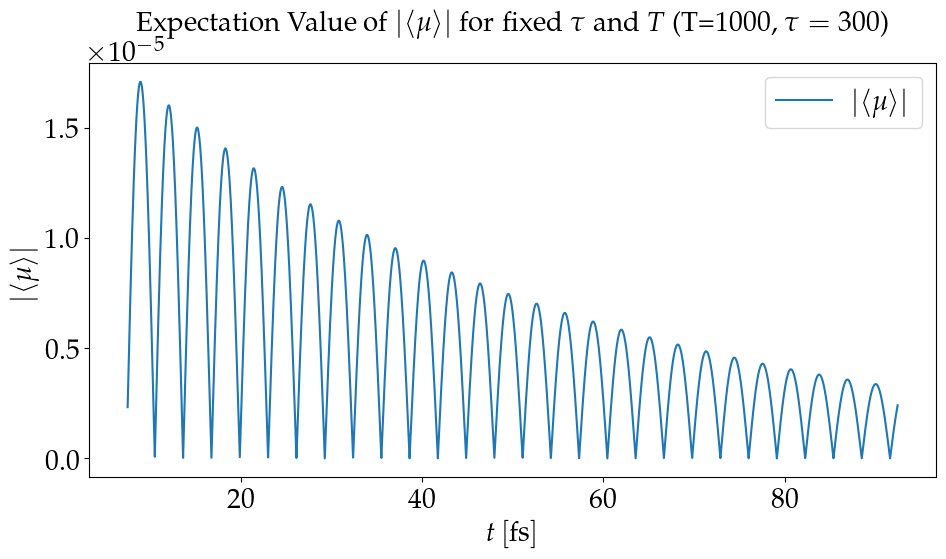

In [16]:
# Test the function and plot the data
tau   = 300
T     = 1000
phi_1 = 0#np.pi/2
phi_2 = 0
plot_fixed_tau_T(tau, T, phi_1, phi_2)

In [ ]:
first_entry = (Delta_ts[1] + Delta_ts[2])
#sparse_spacing  = 10 * fine_spacing         # for waiting times T
#last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
#times_T = np.arange(first_entry, last_entry, sparse_spacing)
times_T =  np.array([0,16,30,46,62,108,140, 310]) + first_entry # np.arange(first_entry, last_entry, sparse_spacing)


### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])

In [ ]:
safe=False
plot_positive_color_map((data_test_0[1], data_test_0[0], data_test_0[2]), T=T_test, safe=safe)
tfreqs = np.fft.fftfreq(len(data_test_0[1]), d=(data_test_0[1][1] - data_test_0[1][0]))
taufreqs = np.fft.fftfreq(len(data_test_0[0]), d=(data_test_0[0][1] - data_test_0[0][0]))
plot_positive_color_map((tfreqs, taufreqs, np.fft.fft2(data_test_0[2])), positive=False, type="real", space="freq", T=T_test, safe=safe)

In [ ]:
# RESULTS from 2D Spectroscopy with all phases and times_T, already averaged over all phi
RESULT = get_all_results(phases, times_T)

In [ ]:
# Example usage
global_time_result, global_freq_result = extend_and_plot_results(RESULT)

In [ ]:
N = 10  # num. cavity modes

# operators
a = tensor(destroy(N), identity(2))
sm = tensor(identity(N), destroy(2))

# expectation operators
e_ops = [a.dag() * a, sm.dag() * sm]

# initial state
psi0 = ket2dm(tensor(basis(N, 1), basis(2, 0)))

w0 = 1.0 * 2 * np.pi
g_weak = 0.1 * 2 * np.pi
g_strong = 0.75 * 2 * np.pi
kappa = 0.05

# collapse operators (for mesolve)
c_ops = [np.sqrt(kappa) * a]
# noise power spectrum (for brmesolve)
a_ops = [[(a + a.dag()), lambda w: kappa * (w > 0)]]

# Hamiltonians
H_no = w0 * a.dag() * a + w0 * sm.dag() * sm
H_weak = w0 * a.dag() * a + w0 * sm.dag() * sm + \
         g_weak * (a + a.dag()) * (sm + sm.dag())
H_strong = w0 * a.dag() * a + w0 * sm.dag() * sm + \
           g_strong * (a + a.dag()) * (sm + sm.dag())


# times for simulation
times = np.linspace(0, 10 * 2 * np.pi / g_weak, 1000)
# simulation
result_me_weak = mesolve(H_weak, psi0, times, c_ops, e_ops)
result_brme_weak = brmesolve(H_weak, psi0, times, a_ops, e_ops)
fig, axes = plot_expectation_values(
    [result_me_weak, result_brme_weak], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['mesolove', 'brmesolve'], loc='upper right')
    
    
# times for simulation
times = np.linspace(0, 10 * 2 * np.pi / g_strong, 1000)
# simulation
result_me_strong = mesolve(H_strong, psi0, times, c_ops, e_ops)
result_brme_strong = brmesolve(H_strong, psi0, times, a_ops, e_ops)
fig, axes = plot_expectation_values(
    [result_me_strong, result_brme_strong], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['mesolove', 'brmesolve'], loc='upper right')

plot_energy_levels([H_no, H_weak, H_strong],
                   h_labels=["no coupling", "weak", "strong"]);





result_brme_nonsec = brmesolve(H_strong, psi0, times, a_ops,
                               sec_cutoff=-1, e_ops=e_ops)
fig, axes = plot_expectation_values(
    [result_brme_strong, result_brme_nonsec], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['brme_strong', 'brme_nonsec'], loc='upper right')



# calculate states for weak coupling
me_states = mesolve(H_weak, psi0, times, c_ops, e_ops=[])
brme_states = brmesolve(H_weak, psi0, times, a_ops, e_ops=[])
# plot the traces and expected trace
plt.axhline(1.0, label="expected trace", c="red", linestyle="--")
plt.plot(times, [state.tr() for state in brme_states.states], label="brme")
plt.plot(times, [state.tr() for state in me_states.states], label="me")
plt.legend(), plt.xlabel("Time"), plt.ylabel("Trace of states");

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:7: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


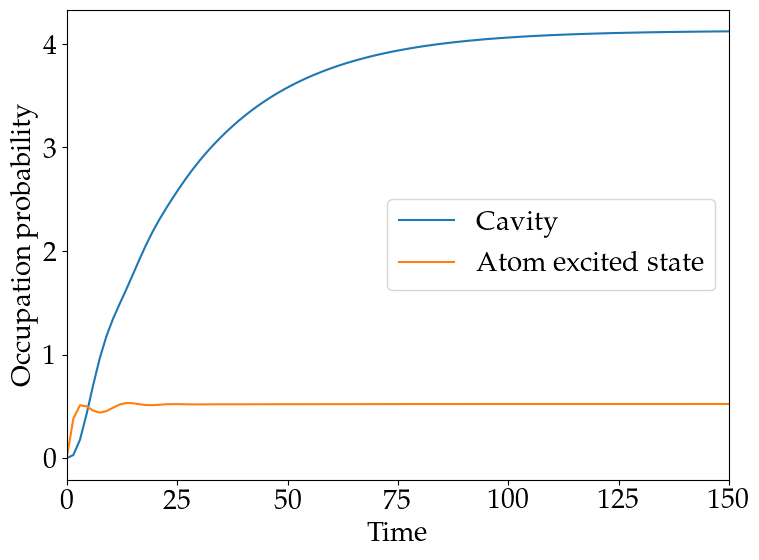

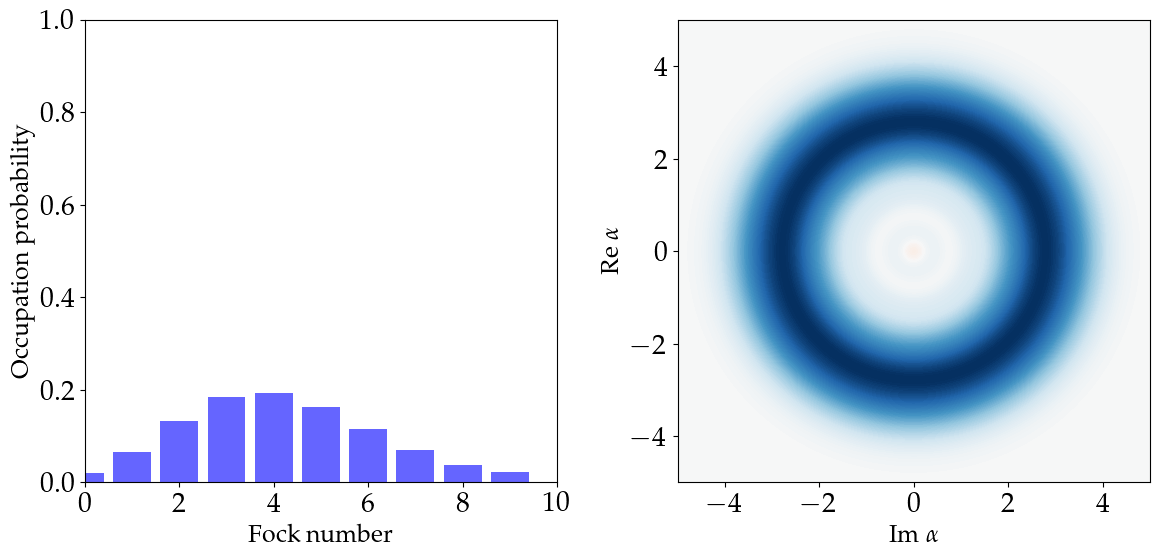

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:7: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


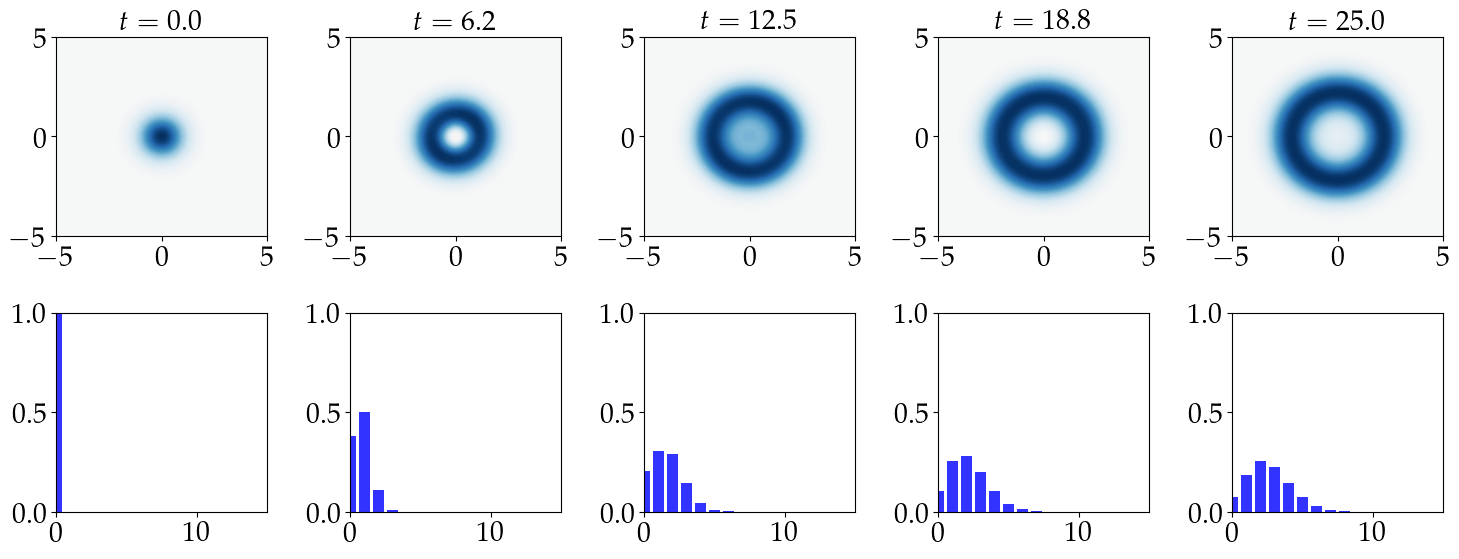

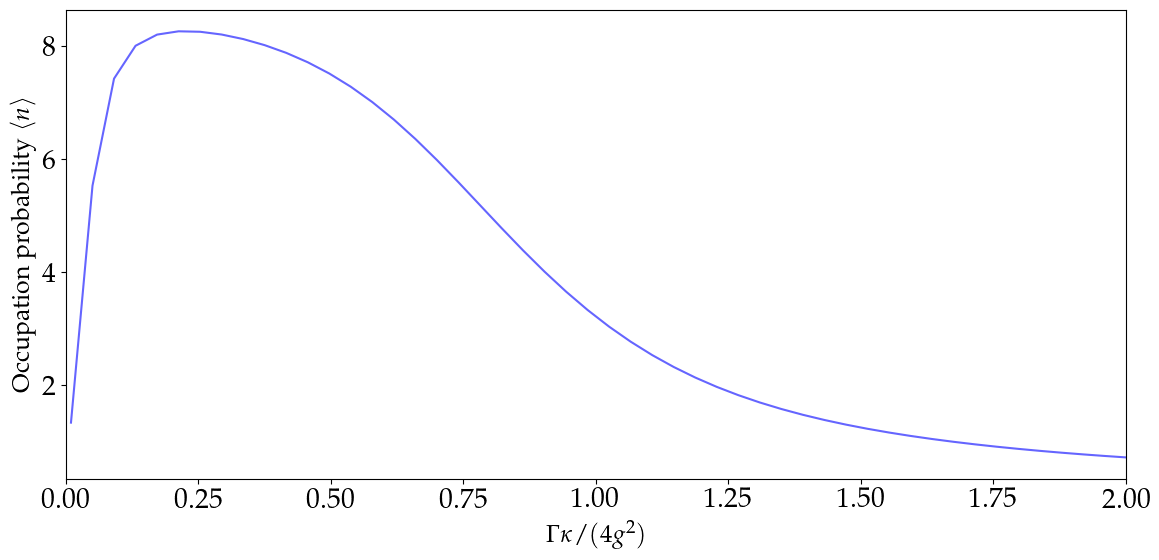

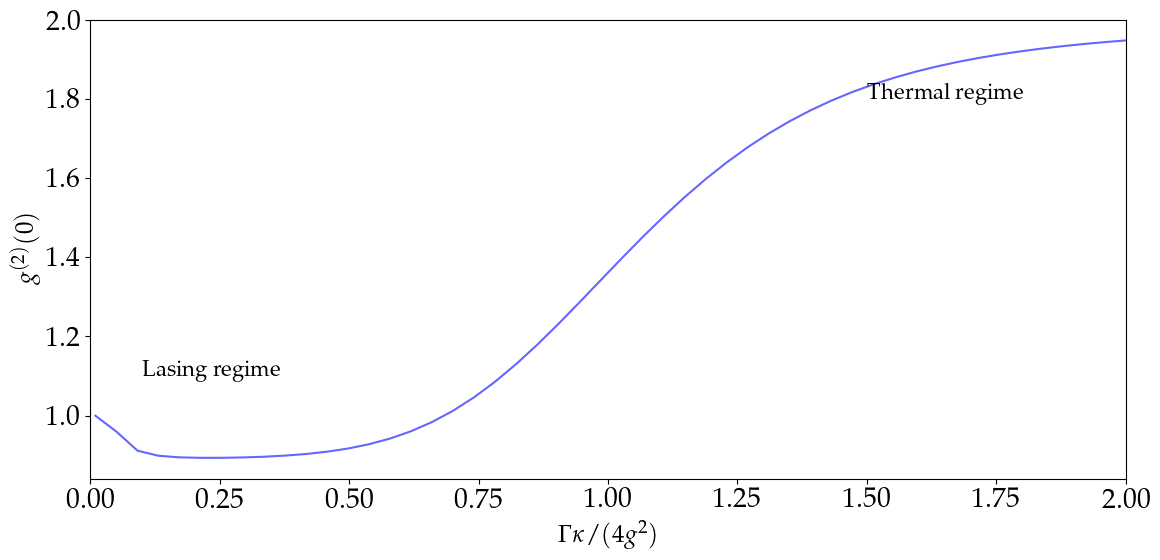

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (
    SolverOptions,
    about,
    basis,
    destroy,
    expect,
    mesolve,
    ptrace,
    qeye,
    sigmax,
    steadystate,
    tensor,
    wigner,
)

# Problem parameters
w0 = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi  # coupling strength

kappa = 0.04  # cavity dissipation rate
gamma = 0.00  # atom dissipation rate
Gamma = 0.35  # atom pump rate

N = 10  # number of cavity fock states
n_th_a = 0.0  # avg number of thermal bath excitation

tlist = np.linspace(0, 150, 101)

# Setup the operators, the Hamiltonian and initial state
psi0 = tensor(basis(N, 0), basis(2, 0))  # start without excitations

a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
sx = tensor(qeye(N), sigmax())

H = w0 * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * sx

# Create a list of collapse operators that describe the dissipation
c_ops = []

rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

rate = Gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm.dag())

# Evolve the system
opt = SolverOptions(nsteps=2000)  # allow extra time-steps
output = mesolve(
    H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm], options=opt
)

# Visualize the results
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Atom excited state")
axes.set_xlim(0, 150)
axes.legend(loc=0)
axes.set_xlabel("Time")
axes.set_ylabel("Occupation probability")

plt.show()

# Steady state: cavity fock-state distribution and wigner function
rho_ss = steadystate(H, c_ops)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

xvec = np.linspace(-5, 5, 200)

rho_cavity = ptrace(rho_ss, 0)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes[1].contourf(
    xvec,
    xvec,
    W,
    100,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=plt.get_cmap("RdBu"),
)
axes[1].set_xlabel(r"Im $\alpha$", fontsize=18)
axes[1].set_ylabel(r"Re $\alpha$", fontsize=18)

axes[0].bar(np.arange(0, N), np.real(rho_cavity.diag()), color="blue", alpha=0.6)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, N)
axes[0].set_xlabel("Fock number", fontsize=18)
axes[0].set_ylabel("Occupation probability", fontsize=18)

plt.show()

# Cavity fock-state distribution and Wigner function as a function of time
tlist = np.linspace(0, 25, 5)
output = mesolve(H, psi0, tlist, c_ops, [], options=SolverOptions(nsteps=5000))

rho_ss_sublist = output.states

xvec = np.linspace(-5, 5, 200)

fig, axes = plt.subplots(2, len(rho_ss_sublist), figsize=(3 * len(rho_ss_sublist), 6))

for idx, rho_ss in enumerate(rho_ss_sublist):
    rho_ss_cavity = ptrace(rho_ss, 0)
    W = wigner(rho_ss_cavity, xvec, xvec)
    wlim = abs(W).max()
    axes[0, idx].contourf(
        xvec,
        xvec,
        W,
        100,
        norm=mpl.colors.Normalize(-wlim, wlim),
        cmap=plt.get_cmap("RdBu"),
    )
    axes[0, idx].set_title(r"$t = %.1f$" % tlist[idx])
    axes[1, idx].bar(
        np.arange(0, N), np.real(rho_ss_cavity.diag()), color="blue", alpha=0.8
    )
    axes[1, idx].set_ylim(0, 1)
    axes[1, idx].set_xlim(0, 15)

plt.show()

# Steady state average photon occupation in cavity as a function of pump rate
def calulcate_avg_photons(N, Gamma):
    c_ops_calc = []

    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
        c_ops_calc.append(np.sqrt(rate) * a)

    rate = kappa * n_th_a
    if rate > 0.0:
        c_ops_calc.append(np.sqrt(rate) * a.dag())

    rate = gamma
    if rate > 0.0:
        c_ops_calc.append(np.sqrt(rate) * sm)

    rate = Gamma
    if rate > 0.0:
        c_ops_calc.append(np.sqrt(rate) * sm.dag())

    rho_ss_calc = steadystate(H, c_ops_calc)
    n_cavity = expect(a.dag() * a, rho_ss_calc)
    g2_cavity = expect(a.dag() * a.dag() * a * a, rho_ss_calc) / (n_cavity**2)

    return n_cavity, g2_cavity

Gamma_max = 2 * (4 * g**2) / kappa
Gamma_vec = np.linspace(0.1, Gamma_max, 50)

n_avg_vec = []
g2_vec = []

for Gamma_val in Gamma_vec:
    n_avg, g2 = calulcate_avg_photons(N, Gamma_val)
    n_avg_vec.append(n_avg)
    g2_vec.append(g2)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.plot(
    Gamma_vec * kappa / (4 * g**2),
    n_avg_vec,
    color="blue",
    alpha=0.6,
    label="numerical",
)

axes.set_xlabel(r"$\Gamma\kappa/(4g^2)$", fontsize=18)
axes.set_ylabel(r"Occupation probability $\langle n \rangle$",
                fontsize=18)
axes.set_xlim(0, 2)

plt.show()

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.plot(Gamma_vec * kappa / (4 * g**2), g2_vec, color="blue", alpha=0.6, label="numerical")
axes.set_xlabel(r"$\Gamma\kappa/(4g^2)$", fontsize=18)
axes.set_ylabel(r"$g^{(2)}(0)$", fontsize=18)
axes.set_xlim(0, 2)
axes.text(0.1, 1.1, "Lasing regime", fontsize=16)
axes.text(1.5, 1.8, "Thermal regime", fontsize=16);

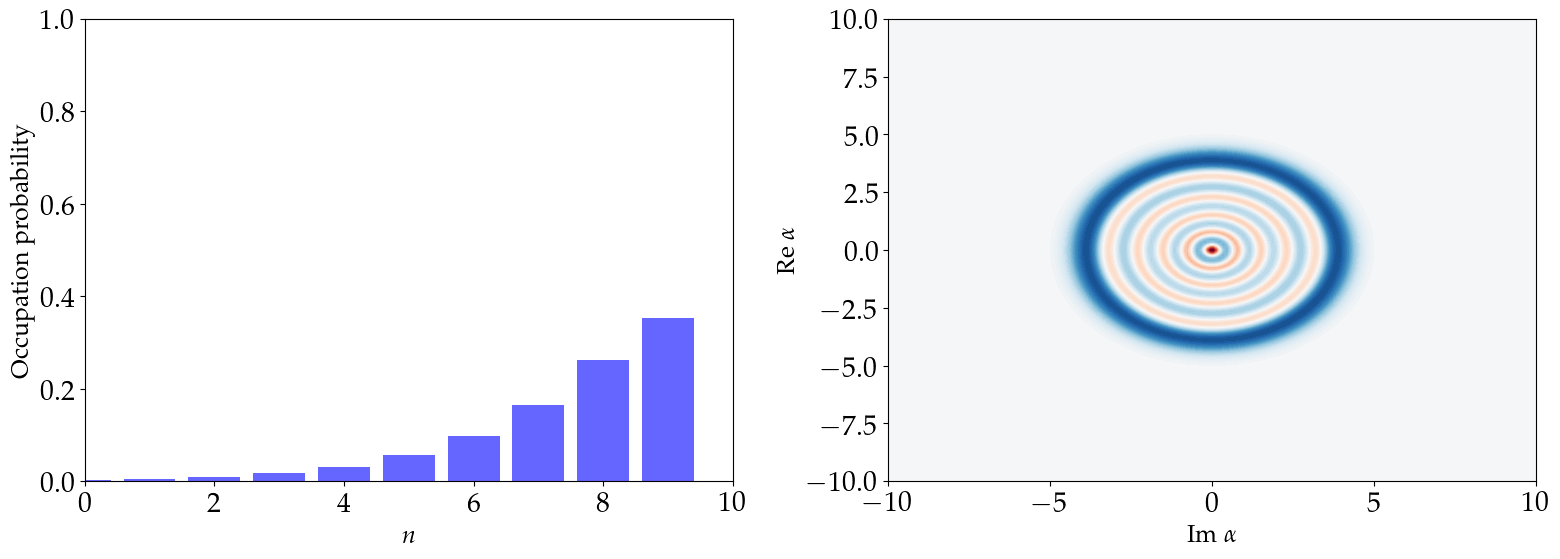

In [13]:
Gamma = 0.5 * (4 * g**2) / kappa
c_ops = [
    np.sqrt(kappa * (1 + n_th_a)) * a,
    np.sqrt(kappa * n_th_a) * a.dag(),
    np.sqrt(gamma) * sm,
    np.sqrt(Gamma) * sm.dag(),
]

rho_ss = steadystate(H, c_ops)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

xvec = np.linspace(-10, 10, 200)

rho_cavity = ptrace(rho_ss, 0)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()
axes[1].contourf(
    xvec,
    xvec,
    W,
    100,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=plt.get_cmap("RdBu"),
)
axes[1].set_xlabel(r"Im $\alpha$", fontsize=18)
axes[1].set_ylabel(r"Re $\alpha$", fontsize=18)

axes[0].bar(np.arange(0, N), np.real(rho_cavity.diag()), color="blue",
            alpha=0.6)
axes[0].set_xlabel(r"$n$", fontsize=18)
axes[0].set_ylabel(r"Occupation probability", fontsize=18)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, N);

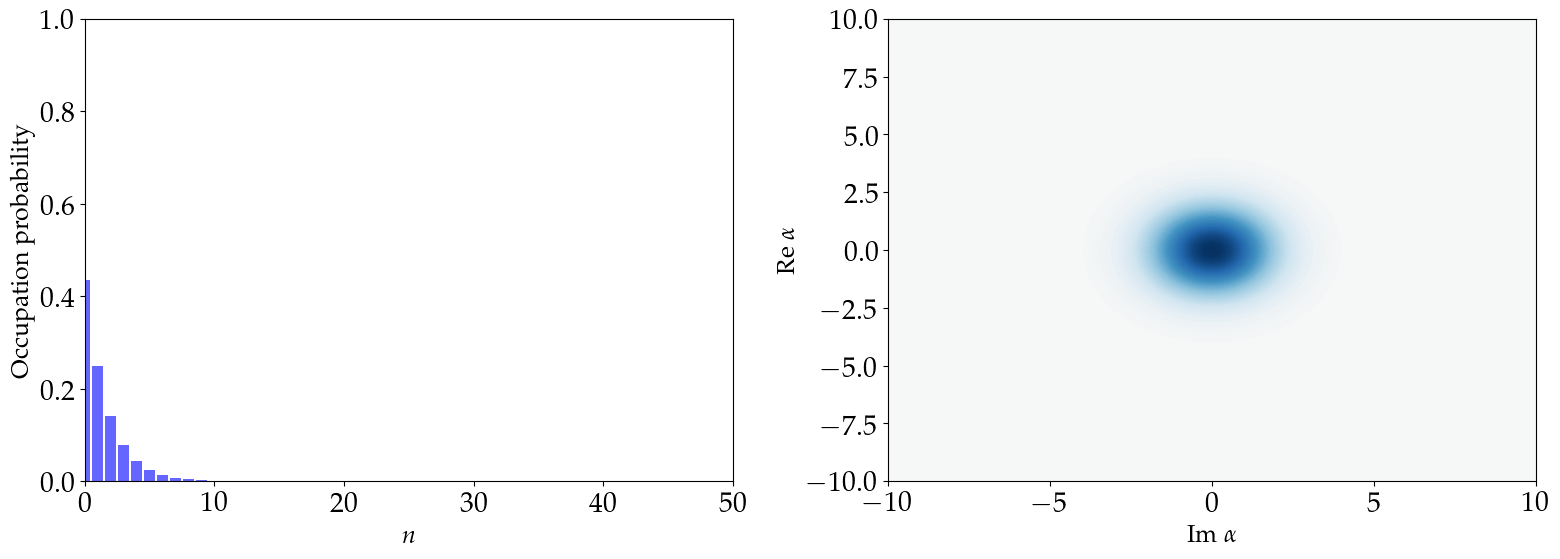

In [11]:
Gamma = 1.5 * (4 * g**2) / kappa
c_ops = [
    np.sqrt(kappa * (1 + n_th_a)) * a,
    np.sqrt(kappa * n_th_a) * a.dag(),
    np.sqrt(gamma) * sm,
    np.sqrt(Gamma) * sm.dag(),
]

rho_ss = steadystate(H, c_ops)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

xvec = np.linspace(-10, 10, 200)

rho_cavity = ptrace(rho_ss, 0)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()
axes[1].contourf(
    xvec,
    xvec,
    W,
    100,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=plt.get_cmap("RdBu"),
)
axes[1].set_xlabel(r"Im $\alpha$", fontsize=18)
axes[1].set_ylabel(r"Re $\alpha$", fontsize=18)

axes[0].bar(np.arange(0, N), np.real(rho_cavity.diag()), color="blue",
            alpha=0.6)
axes[0].set_xlabel(r"$n$", fontsize=18)
axes[0].set_ylabel(r"Occupation probability", fontsize=18)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, N);